# Machine Learning

In this file, instructions how to approach the challenge can be found.

We are going to work on different types of Machine Learning problems:

- **Regression Problem**: The goal is to predict delay of flights.
- **(Stretch) Multiclass Classification**: If the plane was delayed, we will predict what type of delay it is (will be).
- **(Stretch) Binary Classification**: The goal is to predict if the flight will be cancelled.

In [67]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme()

import statsmodels.api as sm
import sklearn

import xgboost as xgb
from sklearn.metrics import mean_squared_error

## Main Task: Regression Problem

The target variable is **ARR_DELAY**. We need to be careful which columns to use and which don't. For example, DEP_DELAY is going to be the perfect predictor, but we can't use it because in real-life scenario, we want to predict the delay before the flight takes of --> We can use average delay from earlier days but not the one from the actual flight we predict.  

For example, variables **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY** shouldn't be used directly as predictors as well. However, we can create various transformations from earlier values.

We will be evaluating your models by predicting the ARR_DELAY for all flights **1 week in advance**.

In [68]:
# Load table
df_numeric = pd.read_csv('../data/df_numeric_with_delays.csv')
df_weather = pd.read_csv('../data/df_weather_aux.csv')
df = df_numeric.copy()
df.head()

,fl_date,origin,dest,crs_dep_time,dep_time,dep_delay,crs_arr_time,arr_time,arr_delay,crs_elapsed_time,...,distance,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,first_dep_time,year,month,day_of_wk
0,2018-10-05,237,248,1655,1655.0,0.0,1825,1806.0,-19.0,150.0,...,764,NaN,NaN,NaN,NaN,NaN,NaN,2018,10,4
1,2018-10-05,304,15,1510,1522.0,12.0,1740,1742.0,2.0,270.0,...,1750,NaN,NaN,NaN,NaN,NaN,NaN,2018,10,4
2,2018-10-05,290,71,1135,1130.0,-5.0,1315,1254.0,-21.0,100.0,...,543,NaN,NaN,NaN,NaN,NaN,NaN,2018,10,4
3,2018-10-05,329,34,1830,1854.0,24.0,2255,2318.0,23.0,145.0,...,1020,0.0,0.0,0.0,0.0,23.0,NaN,2018,10,4
4,2018-10-05,329,152,825,857.0,32.0,1015,1039.0,24.0,110.0,...,601,24.0,0.0,0.0,0.0,0.0,NaN,2018,10,4


In [69]:
df_weather.head()

,max_temp_C,min_temp_C,avg_temp_C,total_snow_cm,sun_hour,uv_index,arr_wind_chill_C,arr_wind_gust_Kmph,arr_cloud_cover,arr_precip_MM,arr_pressure,arr_temp_C,arr_time,arr_uv_index,arr_visibility,arr_weather_code,arr_wind_dir_16Point,arr_wind_dir_degree,arr_wind_speed_Kmph,arr_weather_type
0,31,22,27,0.0,11.6,7,26,5,8,2.4,1017,26,1800,1,9,176,SSW,194,2,Patchy rain possible
1,25,19,23,0.0,11.6,6,23,9,3,0.0,1012,23,1800,1,10,113,WSW,238,8,Clear
2,22,15,19,0.0,8.7,5,22,12,6,0.0,1018,22,1200,6,10,113,WNW,288,10,Sunny
3,31,26,29,0.0,11.6,6,27,10,17,0.9,1015,27,0,1,9,176,SE,138,6,Patchy rain possible
4,18,7,14,0.0,11.6,4,14,7,19,0.0,1018,13,900,4,10,113,SE,143,6,Sunny


In [107]:
# Check for nulls in weather:
# flights Table percent Null content:
df_weather_nulls = df_weather.isnull().sum().sort_values(ascending= False)
perc = (df_weather.isnull().sum()/df_weather.isnull().count()).sort_values(ascending = False)
df_weather_missing_data = pd.concat(
    [df_weather_nulls, perc]
  , axis=1
  , keys=['Total', 'Percent']
  , verify_integrity= True
)
print(f'\nflights_missing_data.head(20)')
display(df_weather_missing_data.head(5))


flights_missing_data.head(20)


,Total,Percent
max_temp_C,0,0.0
min_temp_C,0,0.0
arr_wind_speed_Kmph,0,0.0
arr_wind_dir_degree,0,0.0
arr_wind_dir_16Point,0,0.0


In [109]:
keys = set(list(df_weather['arr_weather_type']))
values = len(keys)
weather_type_code_map = dict(zip(keys, range(values)))
weather_type_code_map

{'Overcast': 0,
 'Light rain': 1,
 'Moderate or heavy freezing rain': 2,
 'Patchy sleet possible': 3,
 'Patchy rain possible': 4,
 'Moderate or heavy rain shower': 5,
 'Patchy light rain': 6,
 'Thundery outbreaks possible': 7,
 'Blizzard': 8,
 'Freezing drizzle': 9,
 'Moderate rain at times': 10,
 'Heavy rain at times': 11,
 'Mist': 12,
 'Sunny': 13,
 'Moderate or heavy snow with thunder': 14,
 'Light snow': 15,
 'Blowing snow': 16,
 'Light snow showers': 17,
 'Patchy light drizzle': 18,
 'Torrential rain shower': 19,
 'Moderate snow': 20,
 'Clear': 21,
 'Patchy freezing drizzle possible': 22,
 'Light freezing rain': 23,
 'Heavy freezing drizzle': 24,
 'Heavy snow': 25,
 'Patchy heavy snow': 26,
 'Light sleet': 27,
 'Cloudy': 28,
 'Patchy snow possible': 29,
 'Light rain shower': 30,
 'Patchy light snow with thunder': 31,
 'Moderate rain': 32,
 'Patchy light rain with thunder': 33,
 'Moderate or heavy showers of ice pellets': 34,
 'Partly cloudy': 35,
 'Moderate or heavy rain with thun

In [112]:
df_weather['arr_weather_type'] = df_weather['arr_weather_type'].map(weather_type_code_map)
df_weather.head()

,max_temp_C,min_temp_C,avg_temp_C,total_snow_cm,sun_hour,uv_index,arr_wind_chill_C,arr_wind_gust_Kmph,arr_cloud_cover,arr_precip_MM,arr_pressure,arr_temp_C,arr_time,arr_uv_index,arr_visibility,arr_weather_code,arr_wind_dir_16Point,arr_wind_dir_degree,arr_wind_speed_Kmph,arr_weather_type
0,31,22,27,0.0,11.6,7,26,5,8,2.4,1017,26,1800,1,9,176,SSW,194,2,4
1,25,19,23,0.0,11.6,6,23,9,3,0.0,1012,23,1800,1,10,113,WSW,238,8,21
2,22,15,19,0.0,8.7,5,22,12,6,0.0,1018,22,1200,6,10,113,WNW,288,10,13
3,31,26,29,0.0,11.6,6,27,10,17,0.9,1015,27,0,1,9,176,SE,138,6,4
4,18,7,14,0.0,11.6,4,14,7,19,0.0,1018,13,900,4,10,113,SE,143,6,13


In [116]:
df_weather.drop(columns=['arr_wind_dir_16Point'], index=1, inplace=True)
df_weather.head()

,max_temp_C,min_temp_C,avg_temp_C,total_snow_cm,sun_hour,uv_index,arr_wind_chill_C,arr_wind_gust_Kmph,arr_cloud_cover,arr_precip_MM,arr_pressure,arr_temp_C,arr_time,arr_uv_index,arr_visibility,arr_weather_code,arr_wind_dir_degree,arr_wind_speed_Kmph,arr_weather_type
0,31,22,27,0.0,11.6,7,26,5,8,2.4,1017,26,1800,1,9,176,194,2,4
2,22,15,19,0.0,8.7,5,22,12,6,0.0,1018,22,1200,6,10,113,288,10,13
3,31,26,29,0.0,11.6,6,27,10,17,0.9,1015,27,0,1,9,176,138,6,4
4,18,7,14,0.0,11.6,4,14,7,19,0.0,1018,13,900,4,10,113,143,6,13
5,20,17,18,0.0,5.7,4,17,19,100,0.1,1020,17,900,4,10,122,26,14,0


Drop the cheater-pants variables:

In [70]:
day_of_delays = [
    'carrier_delay',
    'weather_delay',
    'nas_delay',
    'security_delay',
    'crs_elapsed_time',
    'late_aircraft_delay',
    'dep_delay'
]

df.drop(columns = day_of_delays, axis = 1, inplace = True)

Assign the `target` variable `arr_time` to `y`

In [71]:
# Assign target variable
y = df.arr_delay

# Then drop it from the table:
df.drop(['arr_delay'], axis= 1, inplace= True)
df.head()

,fl_date,origin,dest,crs_dep_time,dep_time,crs_arr_time,arr_time,air_time,distance,first_dep_time,year,month,day_of_wk
0,2018-10-05,237,248,1655,1655.0,1825,1806.0,110.0,764,NaN,2018,10,4
1,2018-10-05,304,15,1510,1522.0,1740,1742.0,242.0,1750,NaN,2018,10,4
2,2018-10-05,290,71,1135,1130.0,1315,1254.0,73.0,543,NaN,2018,10,4
3,2018-10-05,329,34,1830,1854.0,2255,2318.0,130.0,1020,NaN,2018,10,4
4,2018-10-05,329,152,825,857.0,1015,1039.0,84.0,601,NaN,2018,10,4


In [72]:
df.drop(['fl_date'], axis= 1, inplace= True)
df.head()

,origin,dest,crs_dep_time,dep_time,crs_arr_time,arr_time,air_time,distance,first_dep_time,year,month,day_of_wk
0,237,248,1655,1655.0,1825,1806.0,110.0,764,NaN,2018,10,4
1,304,15,1510,1522.0,1740,1742.0,242.0,1750,NaN,2018,10,4
2,290,71,1135,1130.0,1315,1254.0,73.0,543,NaN,2018,10,4
3,329,34,1830,1854.0,2255,2318.0,130.0,1020,NaN,2018,10,4
4,329,152,825,857.0,1015,1039.0,84.0,601,NaN,2018,10,4


In [73]:
df.isna().sum()

origin                0
dest                  0
crs_dep_time          0
dep_time              0
crs_arr_time          0
arr_time              0
air_time             37
distance              0
first_dep_time    88393
year                  0
month                 0
day_of_wk             0
dtype: int64

### Feature Engineering

Feature engineering will play a crucial role in this problems. We have only very little attributes so we need to create some features that will have some predictive power.

- weather: we can use some weather API to look for the weather in time of the scheduled departure and scheduled arrival.
- statistics (avg, mean, median, std, min, max...): we can take a look at previous delays and compute descriptive statistics
- airports encoding: we need to think about what to do with the airports and other categorical variables
- time of the day: the delay probably depends on the airport traffic which varies during the day.
- airport traffic
- unsupervised learning as feature engineering?
- **what are the additional options?**: Think about what we could do more to improve the model.

### Feature Selection / Dimensionality Reduction

We need to apply different selection techniques to find out which one will be the best for our problems.

- Original Features vs. PCA conponents?

##### REMOVING FEATURES WITH SMALL VARIANCE 

Removing columns with little variance which would have small predictive power.


(_Referenced: [W5Em13_Variable_selection](../../../../Documents/LHL%20DS%20Bootcamp/Course%20work/W5/W5Em13_Variable_selection.ipynb)_)

In [74]:
import sklearn
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold(0.1)
df_transformed = vt.fit_transform(df)

to see how many columns were dropped:

In [75]:
print(df.shape)
print(df_transformed.shape)

(88525, 12)
(88525, 12)


In [76]:
# columns we have selected
# VarianceThreshold get_support() stores boolean of each variable in the np.array.
selected_columns = df.columns[vt.get_support()]
print(selected_columns)

# transforming the np.array back to a DataFrame preserves column labels
df_transformed = pd.DataFrame(df_transformed, columns = selected_columns)
df_transformed.head()

Index(['origin', 'dest', 'crs_dep_time', 'dep_time', 'crs_arr_time',
       'arr_time', 'air_time', 'distance', 'first_dep_time', 'year', 'month',
       'day_of_wk'],
      dtype='object')


,origin,dest,crs_dep_time,dep_time,crs_arr_time,arr_time,air_time,distance,first_dep_time,year,month,day_of_wk
0,237.0,248.0,1655.0,1655.0,1825.0,1806.0,110.0,764.0,NaN,2018.0,10.0,4.0
1,304.0,15.0,1510.0,1522.0,1740.0,1742.0,242.0,1750.0,NaN,2018.0,10.0,4.0
2,290.0,71.0,1135.0,1130.0,1315.0,1254.0,73.0,543.0,NaN,2018.0,10.0,4.0
3,329.0,34.0,1830.0,1854.0,2255.0,2318.0,130.0,1020.0,NaN,2018.0,10.0,4.0
4,329.0,152.0,825.0,857.0,1015.0,1039.0,84.0,601.0,NaN,2018.0,10.0,4.0


##### REMOVING CORRELATED FEATURES:

In [77]:
# STEP 1: Correlation matrix
df_corr = df_transformed.corr().abs()

Using `0.8` as the correlation threshold:

In [78]:
# STEP 2: find pairs of highly correlated features
indices = np.where(df_corr > 0.8) 
indices = [(df_corr.index[x], df_corr.columns[y]) 
   for x, y in zip(*indices)
      if x != y and x < y]

Using try-except logic to allows the code to continue in the event a `KeyError` occurs because a high correlation occurred more than once with the same feature.

In [79]:
# STEP 3: Removing the highly correlated columns
for idx in indices: #each pair
    try:
        df_transformed.drop(idx[1], axis = 1, inplace=True)
    except KeyError:
        pass

In [80]:
# The correlated paris are:
indices

[('crs_dep_time', 'dep_time'),
 ('crs_dep_time', 'first_dep_time'),
 ('dep_time', 'first_dep_time'),
 ('crs_arr_time', 'arr_time'),
 ('air_time', 'distance')]

In [81]:
# Recheck shape of table:
print(df_transformed.shape)
df_transformed.head()

(88525, 8)


,origin,dest,crs_dep_time,crs_arr_time,air_time,year,month,day_of_wk
0,237.0,248.0,1655.0,1825.0,110.0,2018.0,10.0,4.0
1,304.0,15.0,1510.0,1740.0,242.0,2018.0,10.0,4.0
2,290.0,71.0,1135.0,1315.0,73.0,2018.0,10.0,4.0
3,329.0,34.0,1830.0,2255.0,130.0,2018.0,10.0,4.0
4,329.0,152.0,825.0,1015.0,84.0,2018.0,10.0,4.0


### Modeling

Use different ML techniques to predict each problem.

- linear / logistic / multinomial logistic regression
- Naive Bayes
- Random Forest
- SVM
- XGBoost
- The ensemble of your own choice

### LINEAR REGRESSION

(_Referenced: [W3D3L Statistical Modeling Demo](../../../../Documents/LHL%20DS%20Bootcamp/Course%20work/W3/W3D3L-Statistical_Modeling_Demo.ipynb)_)

 With `arr_delay` as our dependent variable ($y$) and `_____` and `_______` as our independent variables ($x_1$ and $x_2$). This multiple linear regression model uses the relationship:

$$
y=b_0 + b_1x_1 + b_2x_2
$$

> Note that if we want an intercept ($b_0$) in a `statsmodels OLS` model, we need to use the statsmodels's `add_constant` function, prior to fitting the model.

In [82]:
# Adds a column of 1's so the model will contain an intercept
X = df.copy()
X = sm.add_constant(X) 
X.head()

,const,origin,dest,crs_dep_time,dep_time,crs_arr_time,arr_time,air_time,distance,first_dep_time,year,month,day_of_wk
0,1.0,237,248,1655,1655.0,1825,1806.0,110.0,764,NaN,2018,10,4
1,1.0,304,15,1510,1522.0,1740,1742.0,242.0,1750,NaN,2018,10,4
2,1.0,290,71,1135,1130.0,1315,1254.0,73.0,543,NaN,2018,10,4
3,1.0,329,34,1830,1854.0,2255,2318.0,130.0,1020,NaN,2018,10,4
4,1.0,329,152,825,857.0,1015,1039.0,84.0,601,NaN,2018,10,4


In [83]:
X = X.fillna(0)

In [84]:
# Instantiate linear regression
lin_reg = sm.OLS(y,X)

model = lin_reg.fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              arr_delay   R-squared:                       0.083
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     671.0
Date:                Fri, 13 Jan 2023   Prob (F-statistic):               0.00
Time:                        11:24:14   Log-Likelihood:            -3.6136e+05
No. Observations:               88525   AIC:                         7.228e+05
Df Residuals:                   88512   BIC:                         7.229e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1909.9275    194.850      9.

crs_arr_time P>|t| value is 0.255, so we can drop that variable and re-test:

In [85]:
X.drop('crs_dep_time', axis=1, inplace=True)

In [86]:
# Instantiate linear regression
lin_reg = sm.OLS(y,X)

model = lin_reg.fit()
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:              arr_delay   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.062
Method:                 Least Squares   F-statistic:                     533.0
Date:                Fri, 13 Jan 2023   Prob (F-statistic):               0.00
Time:                        11:24:14   Log-Likelihood:            -3.6238e+05
No. Observations:               88525   AIC:                         7.248e+05
Df Residuals:                   88513   BIC:                         7.249e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           1909.9500    197.095      9.

In [87]:
# Import our model:
from sklearn.linear_model import LinearRegression

Initialize the object and fit the model on our data:

In [88]:
regressor = LinearRegression()
regressor.fit(X, y)

LinearRegression()

In [89]:
# Check the beta coeffient:
print(regressor.coef_)

[ 0.00000000e+00  2.91303771e-03  6.83502995e-04  3.91972405e-03
 -1.35080765e-03  7.57824773e-04  2.71698147e-01 -3.23859272e-02
  1.76906596e-02 -9.54061060e-01  1.28483298e-01 -3.43340655e-02]


### NAIVE BAYES


In [90]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X, y);

In [91]:
# rng = np.random.RandomState(0)
# Xnew = [-6, -14] + [14, 18] * rng.rand(2000, 2)
# ynew = model.predict(Xnew)

### RANDOM FOREST

### SVM

### XGBOOST


_(Referenced: [W6D5m15_Using_XGBoost](../../../../Documents/LHL%20DS%20Bootcamp/Course%20work/W6/W6D5m15_using_XGBoost.ipynb))_

In [92]:
# Generate Dmatrix
data_dmatrix = xgb.DMatrix(data=X,label=y)


Using `train_test_split` to create the test and train for cross-validation.
- `test_size` size = 20% 
- `random_state` used for reproducibility

In [93]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

Instantiating a XGBoost regressor:

In [94]:
xg_reg = xgb.XGBRegressor(
        objective ='reg:squarederror' # Loss function
      , colsample_bytree = 0.3  # % of features used per tree
      , learning_rate = 0.1  # Overfit prevention step size. Range[0,1]
      , max_depth = 5 # Boosting round tree depth
      , alpha = 10  # L1 regularization on leaf weights.
      , n_estimators = 10 # Number of trees to build
)

>Above code was `reg:linear` from class tutorial, but was changed as result of this warning:
>```
>reg:linear is now deprecated in favor of reg:squarederror.
>```

In [95]:
# Fit the training set with .fit():
xg_reg.fit(X_train,y_train)

# Make predictions with .predict():
preds = xg_reg.predict(X_test)

In [96]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 14.938775


In [97]:
# Hyper-parameter dictionary
params = {
      "objective":"reg:squarederror"
    , 'colsample_bytree': 0.3
    , 'learning_rate': 0.1
    , 'max_depth': 5
    , 'alpha': 10
}

# 3-fold cross validation model:
cv_results = xgb.cv(
      dtrain = data_dmatrix
    , params = params
    , nfold = 3
    , num_boost_round = 50
    , early_stopping_rounds = 10
    , metrics = "rmse"
    , as_pandas = True
    , seed = 123
)


>Above code was `reg:linear` from class tutorial, but was changed as result of this warning:
>```
>reg:linear is now deprecated in favor of reg:squarederror.
>```

In [98]:
# Train and test RMSE metrics for each boosting round.
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,16.005618,0.010497,16.010424,0.021688
1,15.797338,0.010661,15.805701,0.023400
2,15.584483,0.045168,15.596683,0.071714
3,15.436779,0.039050,15.451524,0.070525
4,15.279763,0.046708,15.297176,0.052847


In [99]:
print((cv_results["test-rmse-mean"]).tail(1))

49    14.402542
Name: test-rmse-mean, dtype: float64


In [100]:
xg_reg = xgb.train(
      params = params
    , dtrain = data_dmatrix
    , num_boost_round = 10
)

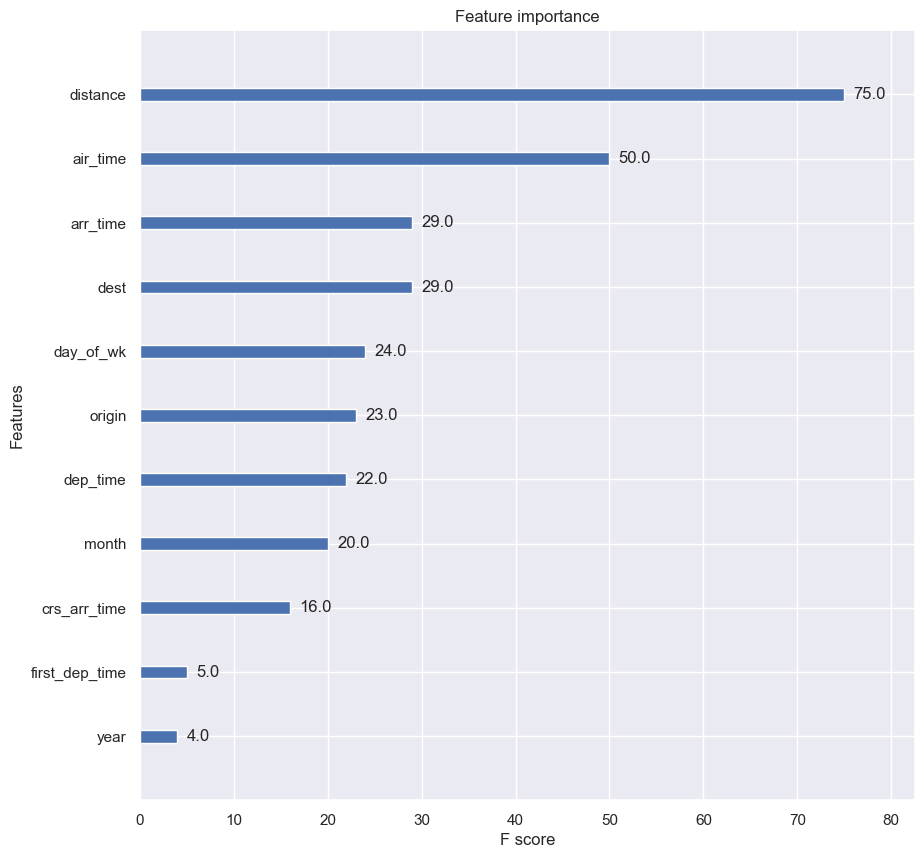

In [101]:
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [10, 10]
plt.show()

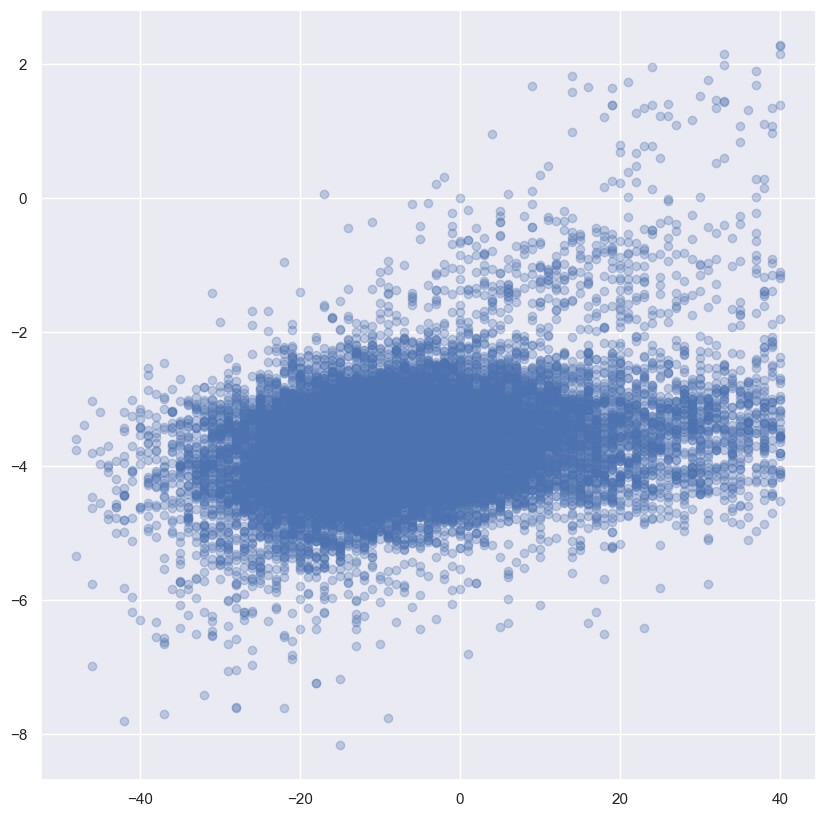

In [102]:
fig = plt.scatter(x= y_test, y= preds, alpha=0.3)

### Evaluation

You have data from 2018 and 2019 to develop models. Use different evaluation metrics for each problem and compare the performance of different models.

You are required to predict delays on **out of sample** data from **first 7 days (1st-7th) of January 2020** and to share the file with LighthouseLabs. Sample submission can be found in the file **_sample_submission.csv_**

_(Referenced: [W6D4m9_Model_evaluation](../../../../Documents/LHL%20DS%20Bootcamp/Course%20work/W6/W6D4m9_model_evaluation.ipynb))_

In [103]:
# import MSE from sklearn
from sklearn.metrics import mean_squared_error

# compute MSE
MSE = mean_squared_error(y_test, preds)  

# print MSE
print(MSE)

223.16699024190777


In [104]:
# # import accuracy_score from sklearn
# from sklearn.metrics import accuracy_score

# # compute accuracy
# accuracy = accuracy_score(y_test, preds)

# # print accuracy
# print(accuracy)

In [105]:
# # import f1_score from sklearn
# from sklearn.metrics import f1_score

# # compute F1-score
# f1_score = f1_score(y_test, preds)

# # print F1-score
# print(f1_score)

======================================================================
## Stretch Tasks

### Multiclass Classification

The target variables are **CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY**. We need to do additional transformations because these variables are not binary but continuos. For each flight that was delayed, we need to have one of these variables as 1 and others 0.

It can happen that we have two types of delays with more than 0 minutes. In this case, take the bigger one as 1 and others as 0.

### Binary Classification

The target variable is **CANCELLED**. The main problem here is going to be huge class imbalance. We have only very little cancelled flights with comparison to all flights. It is important to do the right sampling before training and to choose correct evaluation metrics.